# Sentiment Analysis on Movie Reviews

This is solution implementation to Kaggle's [Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews) competition.

This Competition goal is to apply sentiment analysis techniques on [Rotten Tomatoes dataset](https://www.rottentomatoes.com/).

<b>Quoting from Kaggle's:</b><br/>

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. <br/>
The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order.<br/>
Each Sentence has been parsed into many phrases by the Stanford parser. <br/>
Each phrase has a PhraseId. <br/>
Each sentence has a SentenceId. <br/>
Phrases that are repeated (such as short/common words) are only included once in the data.<br/>


<b>Submission Evaluation</b><br/>
Submissions are evaluated on classification accuracy (the percent of labels that are predicted correctly) for every parsed phrase.<br/>
The sentiment labels are:
- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

This solution got overall <b>accuracy = 0.63392</b> on the test set.

The model used in this solution is <b>LinearSVC</b> with <b>tf-idf</b> based feature vector.

Some another experiments have been done with different features extraction approaches and ML techniques but the one presented in this notebook is the one with the best results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.svm import LinearSVC
from scipy import sparse
from wordcloud import WordCloud
import warnings
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

### Define helper functions

- prepare_text: remove punctuation from text, punctuation including '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
- train_predict: train the classifier and predict the output of the test set.
- stem_input: using PorterStemmer to stem the original phrase.

In [2]:
def prepare_text(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[%s]' % re.escape(string.digits), '', text)
    text = re.sub('[%s]' % re.escape(' +'), ' ', text)
    text = text.lower()
    text = text.strip()
    return text

def train_predict(clf,test_data,train_feature_vector,test_feature_vector,label):
    clf.fit(train_feature_vector,label)
    prediction = clf.predict(test_feature_vector)
    test_data['Sentiment'] = prediction
    submission = test_data[['PhraseId','Sentiment']]
    return submission

def stem_input(row):
    stemmer = PorterStemmer()
    row['stemmed_phrase'] = ' '.join([stemmer.stem(word.strip()).encode('utf-8') for word in row['Phrase'].split(' ')])
    return row

### Data Loading and preparation

In [3]:
train = pd.read_table('train.tsv',delimiter="\t",encoding="utf-8")
test = pd.read_table('test.tsv',delimiter="\t",encoding="utf-8")

<b>Check if the data containes Null or NaNs</b>

In [4]:
train.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [5]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

<b>Convert the sentiment score to its meaningful version to use it during the analysis</b>

In [6]:
train['sentiment_label'] = ''
train.loc[train.Sentiment == 0, 'sentiment_label'] = 'Negative'
train.loc[train.Sentiment == 1, 'sentiment_label'] = 'Somewhat Negative'
train.loc[train.Sentiment == 2, 'sentiment_label'] = 'Neutral'
train.loc[train.Sentiment == 3, 'sentiment_label'] = 'Somewhat Positive'
train.loc[train.Sentiment == 4, 'sentiment_label'] = 'Positive'

In [7]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_label
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,Somewhat Negative
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,Neutral
2,3,1,A series,2,Neutral
3,4,1,A,2,Neutral
4,5,1,series,2,Neutral


<b>Sentiment labels distribution</b>
- The most frequent label is Neutral which represent about 50% from the data.
- The total positive reviews represent about 27%.
- The total negative reviews represent about 23%.

In [8]:
train.sentiment_label.value_counts()

Neutral              79582
Somewhat Positive    32927
Somewhat Negative    27273
Positive             9206 
Negative             7072 
Name: sentiment_label, dtype: int64

In [9]:
train.shape

(156060, 5)

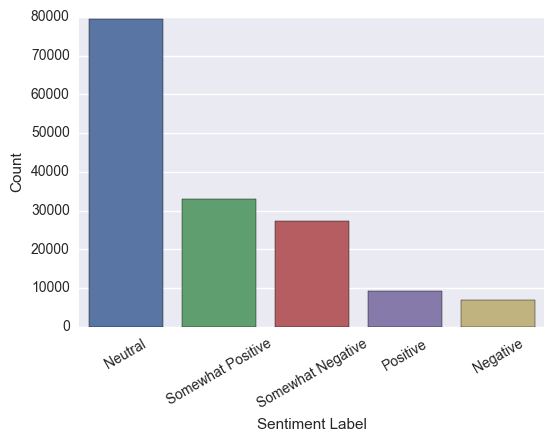

In [10]:
fig, ax = plt.subplots(1, 1,dpi=100)
sentiment_labels = train.sentiment_label.value_counts().index
sentiment_count = train.sentiment_label.value_counts()
sns.barplot(x=sentiment_labels,y=sentiment_count)
ax.set_ylabel('Count')    
ax.set_xlabel('Sentiment Label')
ax.set_xticklabels(sentiment_labels , rotation=30 )

<b>Data Cleaning and Transformation</b>
- Data cleaning by removing the punctuation, digits and multiple spaces from review text.
- Using PorterStemmer to stem the original text to use it as a model features.

In [11]:
train['cleaned_phrase'] = ''
train['cleaned_phrase'] = [prepare_text(phrase) for phrase in train.Phrase]
test['cleaned_phrase'] = ''
test['cleaned_phrase'] = [prepare_text(phrase) for phrase in test.Phrase]

In [12]:
train['stemmed_phrase'] = ''
train = train.apply(stem_input,axis=1)
test['stemmed_phrase'] = ''
test = test.apply(stem_input,axis=1)

In [13]:
train['phrase_length'] = [len(sent.split(' ')) for sent in train.cleaned_phrase]
test['phrase_length'] = [len(sent.split(' ')) for sent in test.cleaned_phrase]

In [14]:
train_phrase_length = sparse.csr_matrix(train.phrase_length)
test_phrase_length = sparse.csr_matrix(test.phrase_length)

In [15]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_label,cleaned_phrase,stemmed_phrase,phrase_length
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,Somewhat Negative,a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story,"A seri of escapad demonstr the adag that what is good for the goos is also good for the gander , some of which occasion amus but none of which amount to much of a stori .",36
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,Neutral,a series of escapades demonstrating the adage that what is good for the goose,A seri of escapad demonstr the adag that what is good for the goos,14
2,3,1,A series,2,Neutral,a series,A seri,2
3,4,1,A,2,Neutral,a,A,1
4,5,1,series,2,Neutral,series,seri,1


In [16]:
test.head()

,PhraseId,SentenceId,Phrase,cleaned_phrase,stemmed_phrase,phrase_length
0,156061,8545,An intermittently pleasing but mostly routine effort .,an intermittently pleasing but mostly routine effort,An intermitt pleas but mostli routin effort .,7
1,156062,8545,An intermittently pleasing but mostly routine effort,an intermittently pleasing but mostly routine effort,An intermitt pleas but mostli routin effort,7
2,156063,8545,An,an,An,1
3,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing but mostly routine effort,intermitt pleas but mostli routin effort,6
4,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing but mostly routine,intermitt pleas but mostli routin,5


### <b>Generate WordClouds for Positive, Negative and Neutral Reviews.</b>

Define a list of english stopwords to be eliminated from the text during text analysis process.

In [17]:
Stopwords = list(ENGLISH_STOP_WORDS) + stopwords.words()

In [26]:
def wordcloud(sentiment):
    stopwordslist = Stopwords
    ## extend list of stopwords with the common words between the 3 classes which is not helpful to represent them
    stopwordslist.extend(['movie','movies','film','nt','rrb','lrb','make','work','like','story','time','little'])
    reviews = train.loc[train.Sentiment.isin(sentiment)]
    print "Word Cloud for Sentiment Labels: ", reviews.sentiment_label.unique()
    phrases = ' '.join(reviews.cleaned_phrase)
    words = " ".join([word for word in phrases.split()])
    wordcloud = WordCloud(stopwords=stopwordslist,width=3000,height=2500,background_color='white',).generate(words)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


Word Cloud for Sentiment Labels:  ['Somewhat Positive' 'Positive']


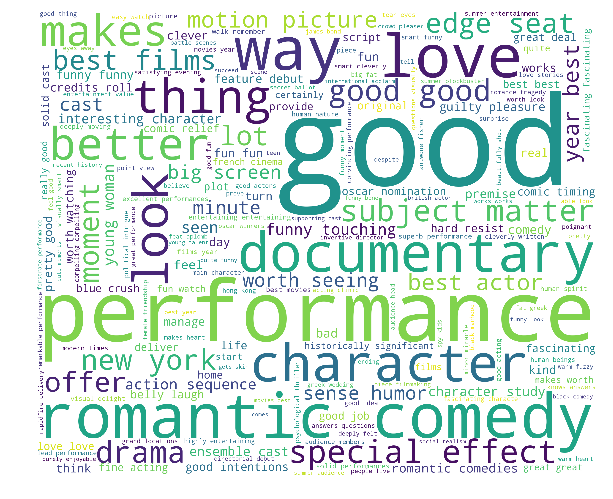

In [19]:
wordcloud([3,4])

Word Cloud for Sentiment Labels:  ['Somewhat Negative' 'Negative']


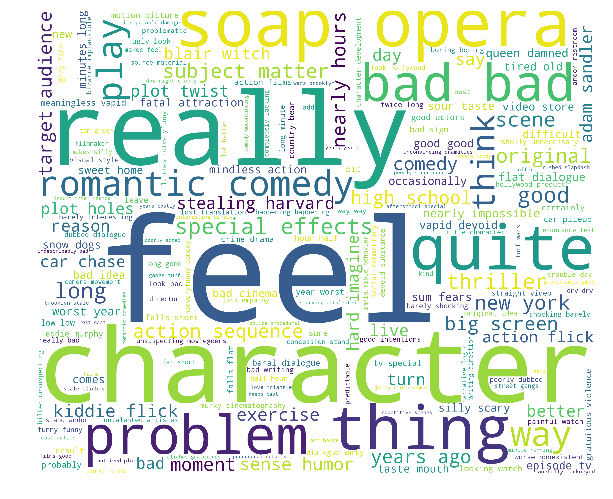

In [27]:
wordcloud([0,1])

Word Cloud for Sentiment Labels:  ['Neutral']


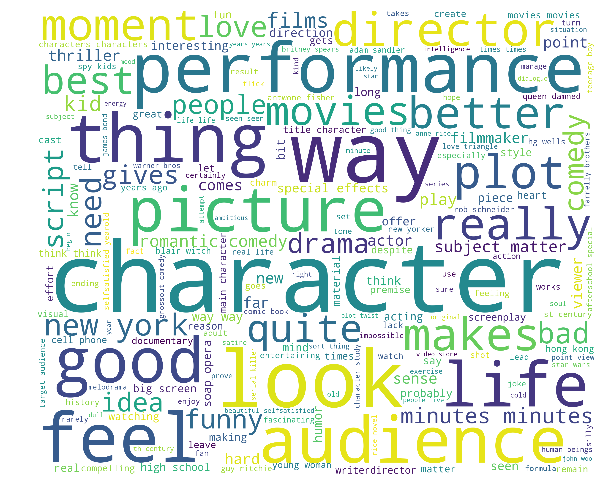

In [21]:
wordcloud([2])

### Extract Features from movie reviews text

#### Tf-Idf Based Features

I will use tf-idf features for both word level and character level, stacking them together and use them to train the model.

In [22]:
tfidf_vectorizer = TfidfVectorizer(analyzer=u'word',stop_words=Stopwords,ngram_range=(1,3), max_df = 0.5, min_df = 5)
train_tf_feature_vector = tfidf_vectorizer.fit_transform(train.cleaned_phrase)
test_tf_feature_vector = tfidf_vectorizer.transform(test.cleaned_phrase)

In [23]:
tfidf_char_vectorizer = TfidfVectorizer(analyzer=u'char',stop_words=Stopwords,ngram_range=(2,6), max_df = 0.5, min_df = 5)
train_tf_char_feature_vector = tfidf_char_vectorizer.fit_transform(train.cleaned_phrase)
test_tf_char_feature_vector = tfidf_char_vectorizer.transform(test.cleaned_phrase)

In [24]:
tf_train = sparse.hstack([train_tf_feature_vector,train_tf_char_feature_vector,train_phrase_length.T])
tf_test = sparse.hstack([test_tf_feature_vector,test_tf_char_feature_vector,test_phrase_length.T])

### Model Building
This solution got overall <b>accuracy = 0.63392</b> on the test set.

In [28]:
SVM_model = LinearSVC()
svm_submission = train_predict(SVM_model,test,tf_train,tf_test,train.Sentiment.values)
svm_submission.to_csv('submission.csv',encoding="utf-8",index=None)